In [ ]:
!pip install transformers
from google.colab import drive
drive.mount('/content/drive')
import sys
sys.path.append('/content/drive/MyDrive/Colab Notebooks/sequences/sequences2')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import dataset_flickr
import dataset_flickr7k
import helper_classes as helper
import nltk
nltk.download('punkt')
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torch.utils import data as data

import time 
import torch
import torch.nn as nn
import torch.optim as optim
import pathlib

import os 

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
CHECKPOINT_DIRECTORY = "model_checkpoints"

# Load Dataset

## Train set 

In [ ]:
import importlib 
importlib.reload(dataset_flickr7k)
# dataset
data_args = {'stage': 'train',
            'ds_path' : "/content/drive/MyDrive/Colab Notebooks/sequences/sequences2", 
            'captions_dir': "",
            'captions_fname': 'results_new.csv',
            'images_dir': '/images_split',
            'freq_threshold': 5}
#train_data = dataset_flickr.Flickr30kData(**data_args)
train_data = dataset_flickr7k.Flickr7kData(**data_args)

print(f"Initialized {len(train_data)} images!") 

length = 6999
stage:  train
ds_path:  /content/drive/MyDrive/Colab Notebooks/sequences/sequences2
captions_f:  /content/drive/MyDrive/Colab Notebooks/sequences/sequences2/results_new.csv
imgs_dir:  /content/drive/MyDrive/Colab Notebooks/sequences/sequences2/images_split/train
Initialized 7736 words in vocabulary
Initialized 34995 images!


## Validation set

In [ ]:
# dataset
data_args = {'stage': 'val',
            'ds_path' : "/content/drive/MyDrive/Colab Notebooks/sequences/sequences2", 
            'captions_dir': "",
            'captions_fname': 'results_new.csv',
            'images_dir': '/images_split',
            'freq_threshold': 5}
#val_data = dataset_flickr.Flickr30kData(**data_args)
val_data = dataset_flickr7k.Flickr7kData(**data_args)

print(f"Initialized {len(val_data)} images!") 

length = 1000
stage:  val
ds_path:  /content/drive/MyDrive/Colab Notebooks/sequences/sequences2
captions_f:  /content/drive/MyDrive/Colab Notebooks/sequences/sequences2/results_new.csv
imgs_dir:  /content/drive/MyDrive/Colab Notebooks/sequences/sequences2/images_split/val
Initialized 7736 words in vocabulary
Initialized 5000 images!


## Test set

In [ ]:
# dataset
data_args = {'stage': 'test',
            'ds_path' : "/content/drive/MyDrive/Colab Notebooks/sequences/sequences2", 
            'captions_dir': "",
            'captions_fname': 'results_new.csv',
            'images_dir': '/images_split',
            'freq_threshold': 5}
#test_data = dataset_flickr.Flickr30kData(**data_args)
test_data = dataset_flickr7k.Flickr7kData(**data_args)

print(f"Initialized {len(test_data)} images!") 

length = 2000
stage:  test
ds_path:  /content/drive/MyDrive/Colab Notebooks/sequences/sequences2
captions_f:  /content/drive/MyDrive/Colab Notebooks/sequences/sequences2/results_new.csv
imgs_dir:  /content/drive/MyDrive/Colab Notebooks/sequences/sequences2/images_split/test
Initialized 7736 words in vocabulary
Initialized 10000 images!


## Set up data loader

In [ ]:
pad_idx = train_data.vocabulary.str_to_idx["<PAD>"]
batch_size = 128

train_loader = DataLoader(
        dataset=train_data,
        batch_size=batch_size,
        shuffle=True,
        collate_fn=helper.CollateCustom(pad_idx),
    )


val_loader = DataLoader (
        dataset=val_data,
        batch_size=batch_size,
        shuffle=True,
        collate_fn=helper.CollateCustom(pad_idx),
    )


test_loader = DataLoader(
        dataset=test_data,
        batch_size=  1,
        shuffle=True,
    )


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

# Attention


## Set up hyperparameters

In [ ]:
"""
TODO:
- need to figure out train/val batch size 
- caption length - how to set this param? 
"""
# Hyperparameters
embed_size = 256
hidden_size = 512 #256
attn_dim = 256 
vocab_size = len(train_data.vocabulary) #len(train_data.vocabulary)
num_layers = 1

learning_rate = 3e-4

## Initialize Model, Loss & optimizer

In [ ]:
import importlib 
#import model_attention as model_attn
import model_attn_2 as model_attn
importlib.reload(model_attn)

<module 'model_attn_2' from '/content/drive/MyDrive/Colab Notebooks/sequences/sequences2/model_attn_2.py'>

In [ ]:
model = model_attn.EncodertoDecoder(embed_size, hidden_size, num_layers, vocab_size, attn_dim).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=train_data.vocabulary.str_to_idx["<PAD>"])
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

Initialized Encoder!
Initialized Decoder!


In [ ]:
idx, X, y= next(iter(train_loader))

## Train model

In [ ]:
#import pathlib
CHECKPOINT_DIRECTORY = "/content/drive/MyDrive/Colab Notebooks/sequences/sequences2/model_checkpoints"

model.train()

start = 1
num_epochs = 30  #60 #ONLY USE MULTIPLES OF 10 
losses = [] 
losses_val = []

time_start = time.time() 

restore_latest_checkpoint = False

if restore_latest_checkpoint:
    #find last checkpoint file based on last modified 
    all_files = pathlib.Path(CHECKPOINT_DIRECTORY).glob('*.pth')
    latest_file = max(all_files, key=os.path.getctime)
    checkpoint_file = str(latest_file).split("/")[1]
    
    #adjust epoch range
    start = int(checkpoint_file.split("_")[2]) + 1 
    num_epochs += start 
    
    #load checkpoint 
    helper.load_checkpoint(checkpoint_file, model, optimizer)

"""
Training
"""
# Early stopping variables
previous_loss = 50
triggered = 0

for epoch in range(start, num_epochs+1):


    batch_loss = 0 
    avg_batch_loss = 0 
    
    for batch_num, (idx, X, y) in enumerate(train_loader):
        X = X.to(device)
        y = y.to(device)

        y_train = y.to(device)
        outputs = model(X, y_train)
        y_target = y[:, 1:].to(device)
        
        loss = criterion(
            outputs.reshape(-1, outputs.shape[2]), 
            y_target.reshape(-1)
        )

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        batch_loss += loss.item()
        
        # if batch_num %100 == 0:
        #     print(f"batch : {batch_num}, loss : {loss.item()}")
            
        #     """show sample caption"""
        #     model.eval()
        #     with torch.no_grad():
        #         idx, images, captions= next(iter(train_loader))
        #         images = images.to(device)
        #         features = model.encoder(images[0:1])
        #         plt.imshow(train_data.plot_img(idx[0]))

        #         # print("Expected: ", train_data.get_image_caption(idx[0]))
        #         # print("Predicted: ", model.generate_caption(features, train_data.vocabulary, 20))
        #     model.train()

    #save loss after every epoch 
    avg_batch_loss = batch_loss/(batch_num+1)
    
        
    """
    Validation
    """
    # run validation set to see find loss 
    batch_loss_val = 0 
    avg_batch_loss_val = 0 
    with torch.no_grad(): 
        #UNCOMMENT THIS 
        for batch_num_val, (idx_val, X_val, y_val) in enumerate(val_loader):
            X_val = X_val.to(device)
            y_val = y_val.to(device)
            
            #skip eos (?) 
            y_train_val = y_val.to(device)

            #calculate loss
            out_val = model(X_val, y_train_val)
            #skip sos for target 
            y_val_target = y_val[:, 1:].to(device)
            
            loss_val = criterion(out_val.reshape(-1, out_val.shape[2]), y_val_target.reshape(-1))
            
            batch_loss_val += loss_val.item()

    #losses_val.append(loss_val.item())#{epoch : loss_val.item()})
    avg_batch_loss_val = batch_loss_val/(batch_num_val+1)

    losses.append([avg_batch_loss, avg_batch_loss_val])


    print(f"Training loss after {epoch} epochs: {loss.item()}\nValidation loss after {epoch} epochs: {loss_val.item()}")
    
    """
    Save checkpoints
    """ 
    if epoch%5 == 0:
        print("Time elapsed: {} min".format((round((time.time()-time_start)/60, 2))))
        #save checkpoint 
        checkpoint = {"state_dict": model.state_dict(),
                    "optimizer": optimizer.state_dict(),
                    "step": epoch
                    }
        fname = "attention_model_" + str(epoch) + "_epochs.pth"
        
        #UNCOMMENT THIS 
        helper.save_checkpoint(checkpoint, fname)
        
    """    
    Early stopping
    """
    current_loss = avg_batch_loss_val

    if current_loss > previous_loss:
        triggered += 1
        print('Early Stopping Trigger Count: ', triggered)

        if triggered >= 3:
            helper.save_model(model.state_dict(), "basic_model.pth")
            print('Early Stopping!')
            break;

    previous_loss = current_loss    
        
                
    #for final epoch 
    if epoch == num_epochs: 
        helper.save_model(model.state_dict(), "attention_model.pth")
             
print("Time elapsed for {} epochs: {} min".format(epoch, 
                                                  round((time.time()-time_start)/60, 2)))
print("loss: ", loss.item())

Training loss after 1 epochs: 4.454128265380859
Validation loss after 1 epochs: 4.163434028625488
Training loss after 2 epochs: 4.029056072235107
Validation loss after 2 epochs: 3.9817214012145996
Training loss after 3 epochs: 3.811450719833374
Validation loss after 3 epochs: 3.291828155517578
Training loss after 4 epochs: 3.506115198135376
Validation loss after 4 epochs: 3.761847972869873
Training loss after 5 epochs: 3.4453299045562744
Validation loss after 5 epochs: 3.5294666290283203
Time elapsed: 41.97 min
Saved checkpoint attention_model_5_epochs.pth!
Training loss after 6 epochs: 3.3046748638153076
Validation loss after 6 epochs: 3.380574941635132
Training loss after 7 epochs: 3.3923192024230957
Validation loss after 7 epochs: 3.1649856567382812
Training loss after 8 epochs: 3.3166940212249756
Validation loss after 8 epochs: 3.3842973709106445
Training loss after 9 epochs: 3.0870521068573
Validation loss after 9 epochs: 3.5726006031036377
Training loss after 10 epochs: 3.1954686

## Plot loss 

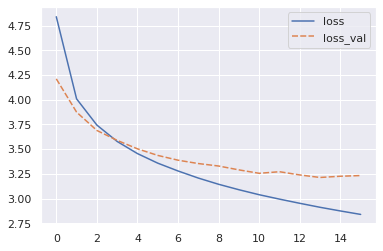

In [16]:
import matplotlib.pyplot as plt 
import seaborn as sns 
import pandas as pd
sns.set() 


if restore_latest_checkpoint: 
    #add to existing losses 
    old_losses = pd.read_csv('loss.csv')[["epochs", "loss", "loss_val"]]
    start_index = old_losses.epochs.max() + 1
    new_data = [[start_index+i, losses[i][0], losses[i][1]] for i in range(len(losses))]
    new_losses = pd.DataFrame(new_data, columns = ["epochs", "loss", "loss_val"])
    loss_df = pd.concat([old_losses, new_losses], keys = ["epochs", "loss", "loss_val"]).reset_index(drop = True)
    
else:
    #create new df 
    loss_df = pd.DataFrame(losses, columns = ['loss', "loss_val"])
    loss_df = loss_df.reset_index().rename(columns= {'index': 'epochs'})
    
loss_df.to_csv("loss.csv")

loss_df
sns.lineplot(data= loss_df.iloc[:, 1:])
#sns.lineplot(data = loss_df, x = "epochs", y = "loss") 

## Test random cases

In [ ]:
#import model 
#find last checkpoint file based on last modified 
all_files = pathlib.Path(CHECKPOINT_DIRECTORY).glob('*.pth')
latest_file = max(all_files, key=os.path.getctime)
checkpoint_file = str(latest_file).split("/")[1]

#print(checkpoint_file)

model = model_attn.EncodertoDecoder(embed_size, hidden_size, num_layers, vocab_size).to(device)

path =  CHECKPOINT_DIRECTORY + "/" +  checkpoint_file
checkpoint = torch.load(path)
model.load_state_dict(checkpoint["state_dict"])

model.eval()
None

In [ ]:
#Load model for inference 
#import model
#model = model.EncodertoDecoder(embed_size, hidden_size, num_layers, vocab_size, extract_features).to(device)
#helper.load_model(model, "basic_model.pth")

#basic_model_170_epochs.pth

#model.eval()
#None

In [ ]:
idx, X, y= next(iter(test_loader))

In [ ]:
X = X.to(device)
features = model.encoder(X)#.to(device)
plt.imshow(test_data.plot_img(idx.item()))
print("Expected: ", test_data.get_image_caption(idx.item()))
print("Predicted: ", model.generate_caption(features, test_data.vocabulary, 20))

In [ ]:
#train_data.plot_img(idx[0])
plt.imshow(test_data.plot_img(idx.item()))
print("Expected: ", test_data.get_image_caption(idx.item()))
print("Predicted: ", model.caption_image_greedy(X.to(device), test_data.vocabulary, 20))

In [ ]:
"""
TODO: when calculating score, compare to any of the reference sentence?
"""
#print("Expected: ", train_data.get_all_captions(idx[0]))
#print("Predicted: ", model.caption_image(X[:1].to(device), train_data.vocabulary))


print("Expected: ", test_data.get_image_caption(idx.item()))
print("Predicted: ", model.caption_image_greedy(X.to(device), test_data.vocabulary, 20))

In [ ]:
test_data.vocabulary.str_to_idx["<EOS>"]

In [ ]:
from PIL import Image as PILImage

fname = test_data.img_files_dict[idx.item()]
path = test_data.imgs_dir + '/' + fname 
img = PILImage.open(path).convert('RGB')

In [ ]:
from torchvision import transforms as transforms

transform_train = transforms.Compose([ 
                transforms.Resize(256),                          # smaller edge of image resized to 256
               # transforms.RandomCrop(224),                      # get 224x224 crop from random location
                transforms.RandomHorizontalFlip(),               # horizontally flip image with probability=0.5
                transforms.ToTensor(),                           # convert the PIL Image to a tensor
                transforms.Normalize((0.485, 0.456, 0.406),      # normalize image for pre-trained model
                                     (0.229, 0.224, 0.225))
]
            )
img = transform_train(img)

In [ ]:
transform = transforms.Compose([
                transforms.Resize((299, 299)),
                transforms.ToTensor()
                #transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
img = transform(img)

In [ ]:
# define a transform to convert a tensor to PIL image
transform = transforms.ToPILImage()

# convert the tensor to PIL image using above transform
my_img= transform(img)

# display the PIL image
my_img.show()

In [ ]:
print(idx[0])
print(train_data.get_image_caption(idx[0]))
print(train_data.get_all_captions(idx[0]))
print(train_data.get_vectorized_caption(idx[0]))
train_data.plot_img(idx[0])